In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import patches
import cv2
import os
import glob
#from PIL import Image
#from IPython.display import display

In [27]:
def DefineRectangles(FileName,PointsPerRectangle):
    #read rectangles
    RectangleRead = pd.read_csv(FileName,sep=" ",names=["x","y","nan"])
    RectangleList = RectangleRead.values.tolist()
    RectanglesAll = np.array(RectangleList)
    RectanglesAll = RectanglesAll[:,[0,1]]
    
    #define rectangles
    x = RectanglesAll[:,0]
    y = RectanglesAll[:,1]
    NumberRectangles = round(len(RectanglesAll[:,0])/PointsPerRectangle)
    RectanglesFinal = np.zeros([2,4,NumberRectangles])
    
    if PointsPerRectangle == 2:
        #assume opposite corners are specified
        for k in range(NumberRectangles):
            RectangleXVertices = []
            RectangleYVertices = []
            for k1 in range(PointsPerRectangle*k,PointsPerRectangle*(k+1),1):
                RectangleXVertices = np.append(RectangleXVertices,x[k1])
                RectangleYVertices = np.append(RectangleYVertices,y[k1])
            
            MinX = np.min(RectangleXVertices)
            MinY = np.min(RectangleYVertices)
            Width = np.abs([RectangleXVertices[1]-RectangleXVertices[0]])
            Height = np.abs([RectangleYVertices[1]-RectangleYVertices[0]])
            MaxX = MinX+Width
            MaxY = MinY+Height
            RectangleXVerticesFinal = np.array([MinX,MaxX,MaxX,MinX])
            RectangleYVerticesFinal = np.array([MinY,MinY,MaxY,MaxY])
            RectanglesFinal[0,:,k] = RectangleXVerticesFinal
            RectanglesFinal[1,:,k] = RectangleYVerticesFinal
            #RectanglesFinal[:,:,k] = [RectangleXVerticesFinal,RectangleYVerticesFinal]
                
    else:
        #assume all 4 vertices are specified
        DistanceFromOriginVertices = np.sqrt(x**2+y**2)
        for k in range(NumberRectangles):   
            RectangleXVertices = []
            RectangleYVertices = []
            DistanceVertices = []
            for k1 in range(PointsPerRectangle*k,PointsPerRectangle*(k+1),1):
                RectangleXVertices = np.append(RectangleXVertices,x[k1])
                RectangleYVertices = np.append(RectangleYVertices,y[k1])
                DistanceVertices = np.append(DistanceVertices,DistanceFromOriginVertices[k1])
            
            RectanglesFinal[:,:,k] = [RectangleXVertices,RectangleYVertices]

            #build?  unfinished code for finding indices enclosed by rectangles

            #find closest vertex to origin
            MaxDistanceVertices = np.max(DistanceVertices)
            #for k2 in range(PointsPerRectangle):
                #if DistanceVertices[k2] == MaxDistanceVertices:
                    #RectangleOrigin = [RectangleXVertices[k2],RectangleYVertices[k2]]


    return RectanglesFinal

In [18]:
def generate_depth_image(FileName,shape,inpaintFlag):
    #code copied from https://github.com/skumra/robotic-grasping/blob/master/utils/dataset_processing/image.py
    img = np.zeros(shape)
    with open(FileName) as f:
        for l in f.readlines():
            ls = l.split()

            if len(ls) != 5:
                # Not a point line in the file.
                continue
            try:
                # Not a number, carry on.
                float(ls[0])
            except ValueError:
                continue

            i = int(ls[4])
            r = i // shape[1]
            c = i % shape[1]

            x = float(ls[0])
            y = float(ls[1])
            z = float(ls[2])
            
            #calculate distance to each point (l2 norm) in point cloud, divide by 1000 to get to m
            img[r, c] = np.sqrt(x ** 2 + y ** 2 + z ** 2)/1000

    if inpaintFlag == 1:
        """
        Inpaint missing values in depth image.
        :param missing_value: Value to fill in teh depth image.
        """
        # cv2 inpainting doesn't handle the border properly
        # https://stackoverflow.com/questions/25974033/inpainting-depth-map-still-a-black-image-border
        img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_DEFAULT)
        mask = (img == 0).astype(np.uint8)

        # Scale to keep as float, but has to be in bounds -1:1 to keep opencv happy.
        scale = np.abs(img).max()
        img = img.astype(np.float32) / scale  # Has to be float32, 64 not supported.
        img = cv2.inpaint(img, mask, 1, cv2.INPAINT_NS)

        # Back to original size and value range.
        img = img[1:-1, 1:-1]
        img = img * scale
    
    return img


In [80]:
def CreatePatch(RGBDImage,Rectangles):
    #break apart rgb and depth
    RGBImage = RGBDImage[:,:,[0,1,2]]
    RGBImage = RGBImage.astype(np.uint8)
    
    PatchImage = np.zeros(RGBImage.shape)
    PatchImage = PatchImage.astype(np.uint8)
    
    #extract indices from positive rectangles
    LimitsPatchIndex = np.zeros([4,len(Rectangles[0,0,:])])
    for k in range(len(Rectangles[0,0,:])):
        xminIndex = round(Rectangles[0,0,k])
        xmaxIndex = round(Rectangles[0,1,k])
        yminIndex = round(Rectangles[1,0,k])
        ymaxIndex = round(Rectangles[1,-1,k])
        LimitsPatchIndex[:,k] = [xminIndex,xmaxIndex,yminIndex,ymaxIndex]
        
        for k1 in range(xminIndex,xmaxIndex):
            for k2 in range(yminIndex,ymaxIndex):
                PatchImage[k2,k1,:] = RGBImage[k2,k1,:]
    
    YUVImage = cv2.cvtColor(PatchImage, cv2.COLOR_BGR2YUV)

                    #y, u, v = cv2.split(img_yuv)
    
    return YUVImage


In [85]:
#load data files
data_folder = os.path.join(os.path.dirname(os.getcwd()), "data_592", "robotics_grasp", "10")
print("Current Directory:", data_folder)

cneg_pattern = "*cneg.txt"
cpos_pattern = "*cpos.txt"
pcd_pattern = "pcd[0-9][0-9][0-9][0-9].txt"
png_pattern = "*.png"
tiff_pattern = "*.tiff"

cneg_files = sorted(glob.glob(os.path.join(data_folder, cneg_pattern)))
cpos_files = sorted(glob.glob(os.path.join(data_folder, cpos_pattern)))
pcd_files = sorted(glob.glob(os.path.join(data_folder, pcd_pattern)))
png_files = sorted(glob.glob(os.path.join(data_folder, png_pattern)))

ImageIndex = 31
FileNameImage = png_files[ImageIndex]
FileNameDepthImage = pcd_files[ImageIndex]
FileNameNegRect = cneg_files[ImageIndex]
FileNamePosRect = cpos_files[ImageIndex]

#FileNameImage = '/home/exouser/ME592_Spring2024/data_592/robotics_grasp/10/pcd1031r.png'
#FileNameDepthImage = '/home/exouser/ME592_Spring2024/data_592/robotics_grasp/10/pcd1031.txt'
#FileNameNegRect = '/home/exouser/ME592_Spring2024/data_592/robotics_grasp/pcd1000cneg.txt'
#FileNamePosRect = '/home/exouser/ME592_Spring2024/data_592/robotics_grasp/10/pcd1000cpos.txt'

Current Directory: /home/exouser/ME592_Spring2024/data_592/robotics_grasp/10


/tmp/ipykernel_3599/4060048855.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RectangleXVerticesFinal = np.array([MinX,MaxX,MaxX,MinX])
/tmp/ipykernel_3599/4060048855.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  RectangleYVerticesFinal = np.array([MinY,MinY,MaxY,MaxY])
/tmp/ipykernel_3599/4060048855.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

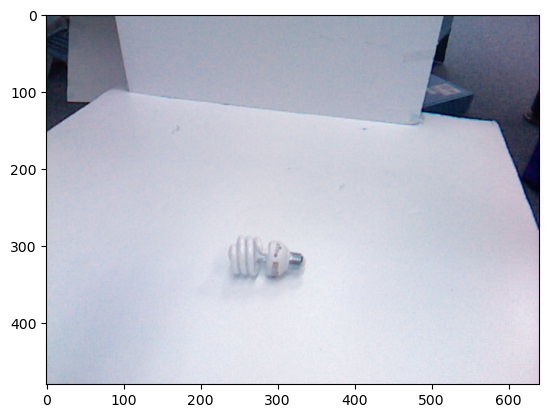

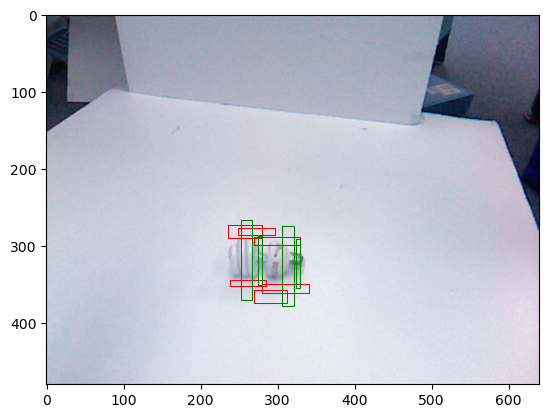

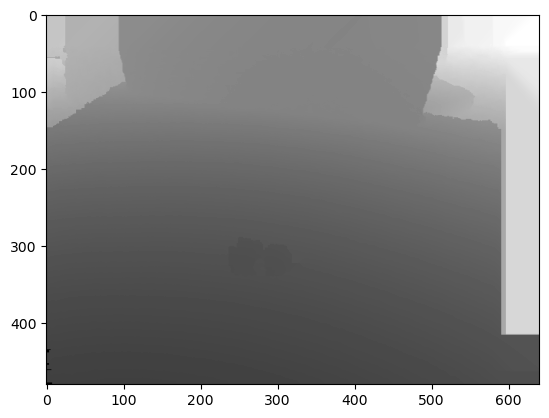

In [87]:
#process data files

#load image
Image1 = cv2.imread(FileNameImage)
shape = [len(Image1[:,0]),len(Image1[0,:])]

#define grasping triangles
PointsPerRectangle = 2
RectanglesNegative = DefineRectangles(FileNameNegRect,PointsPerRectangle)
RectanglesPositive = DefineRectangles(FileNamePosRect,PointsPerRectangle)

#create depth image
inpaintFlag = 1;
depth_image = generate_depth_image(FileNameDepthImage,shape,inpaintFlag)

#plot original image
plt.imshow(Image1)
plt.show()
#plot image with grasping triangles
plt.imshow(Image1)
for k in range(len(RectanglesNegative[0,0,:])):
    xvalues = np.append(RectanglesNegative[0,:,k],RectanglesNegative[0,0,k])
    yvalues = np.append(RectanglesNegative[1,:,k],RectanglesNegative[1,0,k])
    plt.plot(xvalues,yvalues,color="red",linewidth=0.75)
for k in range(len(RectanglesPositive[0,0,:])):
    xvalues = np.append(RectanglesPositive[0,:,k],RectanglesPositive[0,0,k])
    yvalues = np.append(RectanglesPositive[1,:,k],RectanglesPositive[1,0,k])    
    plt.plot(xvalues,yvalues,color="green",linewidth=0.75)
plt.show()
#plot grayscale depth image
plt.imshow(depth_image,cmap="gray")
plt.show()

[480, 640, 4]


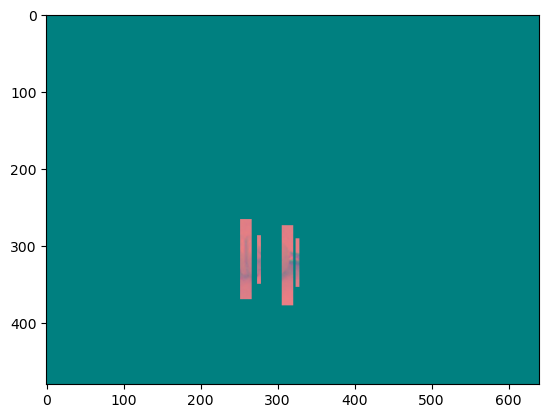

In [88]:
#build rgbd image array, build patches

#rbgd array
rgbd_image = np.zeros([len(Image1[:,0]),len(Image1[0,:]),4])
rgbd_image[:,:,[0,1,2]] = Image1
rgbd_image[:,:,3] = depth_image
print([len(rgbd_image[:,0,0]),len(rgbd_image[0,:,0]),len(rgbd_image[0,0,:])])
#rgb in rgbd image is now a float, need to convert back to uint8 before plotting
#and converting to yuv

yuvd_image = CreatePatch(rgbd_image,RectanglesPositive)

plt.imshow(yuvd_image)
plt.show()
